In [1]:
%load_ext lab_black

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


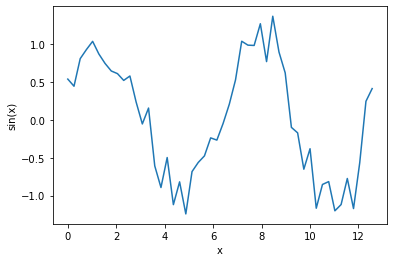

In [3]:
# 訓練データ
x = np.linspace(0, 4 * np.pi)
sin_x = np.sin(x) + np.random.normal(0, 0.3, len(x))
plt.plot(x, sin_x)
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()

In [4]:
# ハイパーパラメータ
n_time = 10
n_sample = len(x) - n_time

# データを格納する空の配列を準備
input_data = np.zeros((n_sample, n_time, 1))
correct_data = np.zeros((n_sample, 1))

# 前処理
for i in range(n_sample):
    input_data[i] = sin_x[i : i + n_time].reshape(-1, 1)
    correct_data[i] = [sin_x[i + n_time]]
input_data = torch.FloatTensor(input_data)
correct_data = torch.FloatTensor(correct_data)

# バッチデータの準備
dataset = TensorDataset(input_data, correct_data)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
# モデルの定義
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(device)
        x_rnn, hidden = self.rnn(x, None)
        x = self.fc(x_rnn[:, -1, :])
        return x


model = RNN().to(device)

In [6]:
# 最適化手法の定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 誤差(loss)を記録する空の配列を用意
record_loss_train = []

Epoch: 0 Loss_Train: 0.5182808220386506


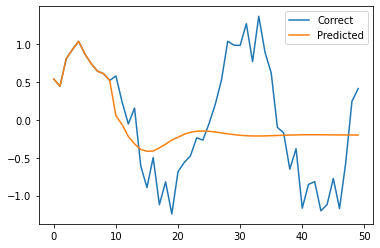

Epoch: 10 Loss_Train: 0.10748285204172134


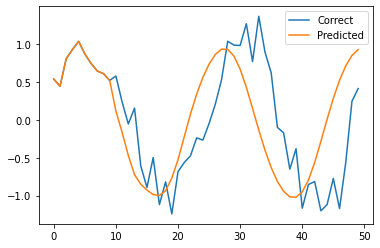

Epoch: 20 Loss_Train: 0.08316502347588539


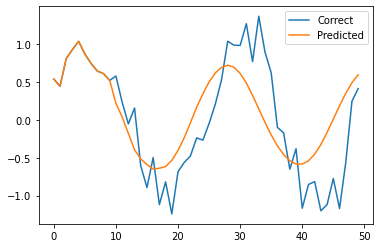

Epoch: 30 Loss_Train: 0.08137081265449524


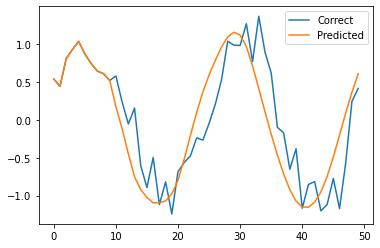

Epoch: 40 Loss_Train: 0.08511365503072739


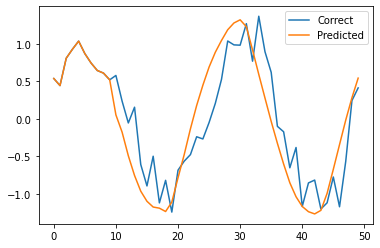

Epoch: 50 Loss_Train: 0.08744844496250152


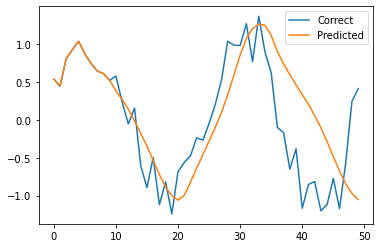

Epoch: 60 Loss_Train: 0.08459471985697746


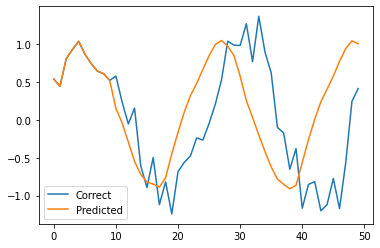

Epoch: 70 Loss_Train: 0.07044845297932625


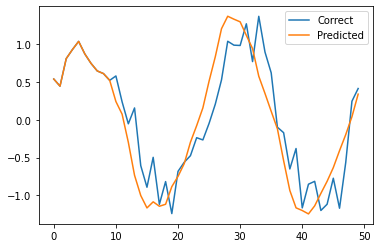

Epoch: 80 Loss_Train: 0.04910463541746139


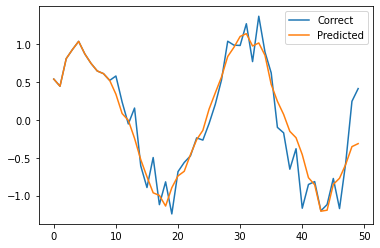

Epoch: 90 Loss_Train: 0.030639386922121047


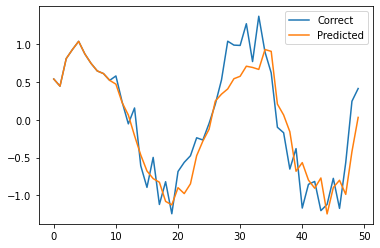

Epoch: 100 Loss_Train: 0.010235709929838776


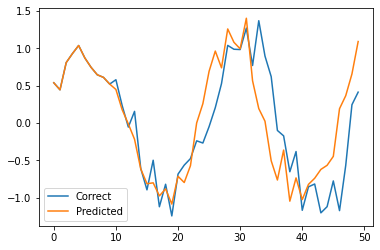

Epoch: 110 Loss_Train: 0.006284564943052828


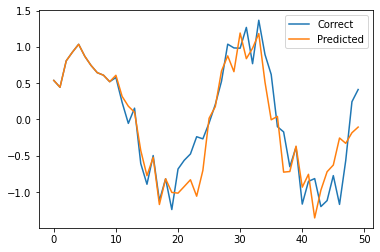

Epoch: 120 Loss_Train: 0.0033090971410274506


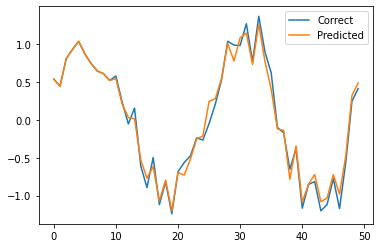

Epoch: 130 Loss_Train: 0.0016680159373208881


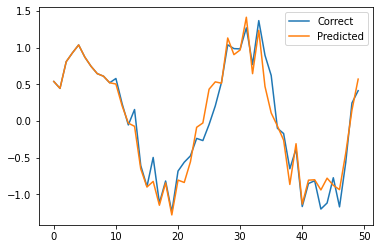

Epoch: 140 Loss_Train: 0.005396182578988373


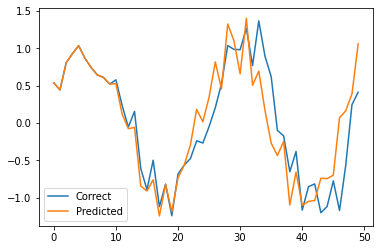

Epoch: 150 Loss_Train: 0.004093052307143808


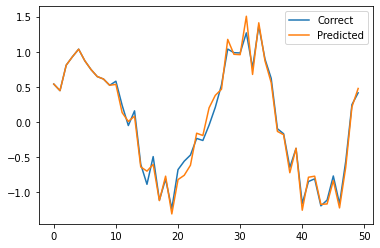

Epoch: 160 Loss_Train: 0.0007832759874872863


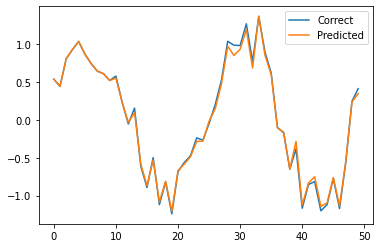

Epoch: 170 Loss_Train: 0.007558908453211189


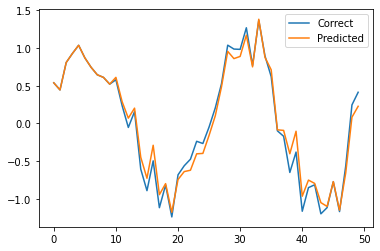

Epoch: 180 Loss_Train: 0.014713787101209163


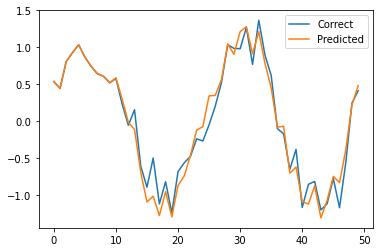

Epoch: 190 Loss_Train: 0.004295515059493482


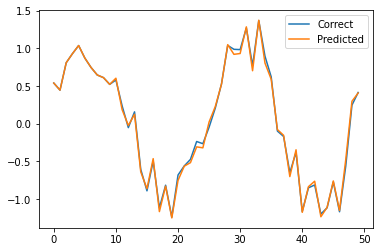

Epoch: 200 Loss_Train: 0.001490660011768341


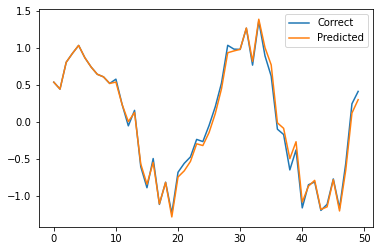

In [7]:
# 学習
for i in range(201):
    model.train()
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
        loss = criterion(model(x), t.to(device))
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j + 1
    record_loss_train.append(loss_train)
    if i % 10 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        predicted = list(input_data[0].reshape(-1))
        model.eval()
        with torch.no_grad():
            for i in range(n_sample):
                x = torch.tensor(predicted[-n_time:])
                x = x.reshape(1, n_time, 1)
                predicted.append(model(x)[0].item())
        plt.plot(range(len(sin_x)), sin_x, label="Correct")
        plt.plot(range(len(predicted)), predicted, label="Predicted")
        plt.legend()
        plt.show()

最初の誤差： 51.83 %
最終の誤差　： 0.15  %


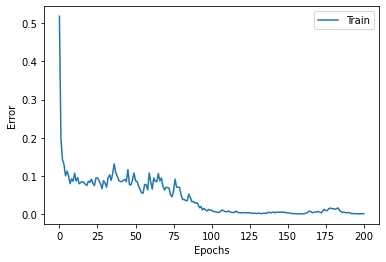

In [8]:
# 精度の確認
print("最初の誤差：", round(record_loss_train[0] * 100, 2), "%")
print("最終の誤差　：", round(record_loss_train[-1] * 100, 2), " %")
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()